In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt 
from math import floor

class Group:
    def __init__(self):
        # Initialize a group with an ID and a dictionary to track user interactions
        self.id = 0
        self.interactions = {}

class User:
    def __init__(self, alpha, beta):
        # Initialize a user with ID, group memberships, interaction history, and Beta distribution preferences
        self.id = 0
        self.groups = []
        self.interaction_history = []
        self.preferences = stats.beta(alpha, beta)

    def update_preferences(self):
        # Update user's preferences based on group interactions
        if not self.groups:
            self.updated_preferences = np.array([1])
            return
        else:
            #sort groups by number of interactions
            self.groups.sort(key=lambda group: len(group.interactions))

        total_size = sum([len(group.interactions) for group in self.groups])
        if total_size == 0:
            self.ccdf = np.array([1 / len(self.groups)] * len(self.groups))
        else:
            sizes = sorted([len(group.interactions) for group in self.groups])
            self.ccdf = 1- (np.cumsum(sizes) / total_size)

        self.updated_preferences = np.convolve(self.preferences.pdf(np.linspace(0, 1, len(self.groups))), self.ccdf , mode='same')

        if np.isnan(self.updated_preferences).any() or np.sum(self.updated_preferences) == 0:
            self.updated_preferences = np.array([1 / len(self.groups)] * len(self.groups))
        else:
            self.updated_preferences /= np.sum(self.updated_preferences)

    def join_group(self, group):
        # Add a group to the user's group list and set initial interactions to 0
        self.groups.append(group)
        group.interactions[self] = 0

    def interact(self, group: Group):
        # Record an interaction with the specified group
        group.interactions[self] += 1
        self.interaction_history.append(group.id)

# Initialize lists to store users and groups
users = []
groups = []
num_groups = len(groups)

# Define simulation parameters
user_growth_rate = 0.05
group_join_rate = 0.00625
new_group_threshold = 0.005
interaction_threshold = 1.1
num_timesteps = 300
alpha_hyperparameter = 10
beta_hyperparameter = 10 
initial_users = 10
initial_groups = 5


# Data structure for regression analysis
data_for_regression = []

# Create initial users and groups
for _ in range(initial_users):
    user = User(np.random.uniform(1, alpha_hyperparameter), np.random.uniform(1, beta_hyperparameter))
    users.append(user)
    user.id = len(users)

for _ in range(initial_groups):
    group = Group()
    groups.append(group)
    group.id = len(groups) + 1

# Initial user-group interactions
for user in users:
    for _ in range(floor(stats.expon.rvs(group_join_rate))):
        group = np.random.choice(groups)
        user.join_group(group)
    user.update_preferences()

# Main simulation loop
for _ in range(num_timesteps):
    for _ in range(floor(stats.expon.rvs(user_growth_rate))): 
        user = User(np.random.uniform(1, alpha_hyperparameter), np.random.uniform(1, beta_hyperparameter))
        users.append(user)
        user.id = len(users)

    for user in users:
        for _ in range(floor(stats.expon.rvs(group_join_rate))):
            if np.random.uniform() < new_group_threshold:
                group = Group()
                user.join_group(group)
                groups.append(group)
                group.id = len(groups) + 1
            else:
                group = np.random.choice(groups)
                user.join_group(group) 

        if user.groups:
            user.update_preferences()
        else:
            user.updated_preferences = np.array([1])

        num_groups = len(groups)

        if np.random.uniform() < interaction_threshold and user.groups:
            group = np.random.choice(user.groups, p=user.updated_preferences)
            user.interact(group)
            current_group = user.interaction_history[-1]
        else:
            user.interaction_history.append(1)
            current_group = user.interaction_history[-1]

        if len(user.interaction_history) > 1:
            previous_group = user.interaction_history[-2]
            interactions_by_group = np.bincount(user.interaction_history, minlength=num_groups)
            data_for_regression.append([user.id,current_group, *interactions_by_group])
        else:
            previous_group = current_group
            interactions_by_group = np.bincount(user.interaction_history, minlength=num_groups)
            data_for_regression.append([user.id,current_group, *interactions_by_group])



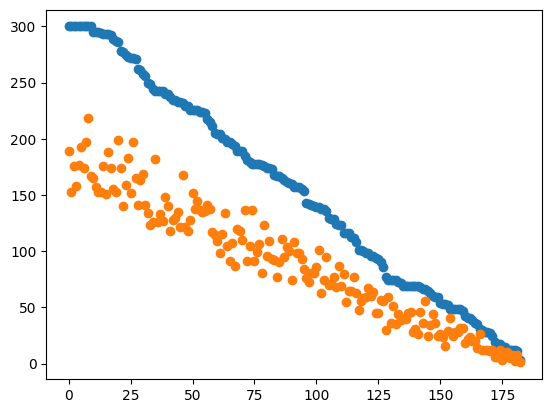

In [9]:
plt.scatter(range(len(users)),[len(user.interaction_history) for user in users])
plt.scatter(range(len(users)),[len(user.updated_preferences) for user in users])


In [4]:
import stan
import arviz as az
import nest_asyncio
from itertools import chain
nest_asyncio.apply()

N = len(users)
K = len(groups)
D = len(groups)
Y = np.zeros(N)
X = np.zeros((N, D))

for user in users:
    # Filter data for user
    user_data = [row for row in data_for_regression if row[0] == user.id]
    
    final_entry = user_data[-1]
  
    if len(final_entry) - 2 < D:
        final_entry += [0] * (D - len(final_entry) + 2)

    Y[user.id - 1] = final_entry[1]
    X[user.id - 1] = final_entry[2:]

Y = Y.astype(int)

for row in X:
    row /= np.sum(row)

X = np.where(X == 0, 0.0001, X)

stan_code = """
data {
  int K;
  int N;
  int D;
  array[N] int Y;
  matrix[N, D] X;
}
parameters {
  matrix[D, K] beta;
}
model {
  matrix[N, K] x_beta = X * beta;

  to_vector(beta) ~ normal(0, 1);

  for (n in 1:N) {
    Y[n] ~ categorical_logit(x_beta[n]');

  }
}
"""



In [5]:
model = stan.build(stan_code, data={'K' : K, 'N' : N, 'D' : D, 'Y' : Y, 'X' : X.astype(float)})
fit = model.sample(num_chains=4, num_samples=1000)

Building...



Building: found in cache, done.Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% (1800/8000)
Sampling:  24% (1900/8000)
Sampling:  25% (2000/8000)
Sampling:  26% (2100/8000)
Sampling:  28% (2200/8000)
Sampling:  29% (2300/8000)
Sampling:  30% (2400/8000)
Sampling:  31% (2500/8000)
Sampling:  32% (2600/8000)
Sampling:  34% (2700/8000)
Sampling:  35% (2800/8000)
Sampling:  36% (2900/8000)
Sampling:  38% (3000/8000)
Sampling:  39% (3100/8000)
Sampling:  40% (3200/8000)
Sa

In [6]:
az_data = az.from_pystan(posterior=fit)

In [7]:
az.summary(az_data, round_to=2, kind='stats')

,mean,sd,hdi_3%,hdi_97%
"beta[0, 0]",-0.00,1.04,-1.96,1.95
"beta[0, 1]",0.00,0.99,-1.87,1.84
"beta[0, 2]",0.02,1.01,-2.03,1.81
"beta[0, 3]",0.01,1.03,-1.89,1.94
"beta[0, 4]",0.01,0.99,-1.76,1.87
...,...,...,...,...
"beta[102, 98]",0.01,0.95,-1.79,1.75
"beta[102, 99]",0.01,0.95,-1.91,1.71
"beta[102, 100]",-0.00,1.02,-1.85,1.95
"beta[102, 101]",0.00,1.01,-1.75,1.96


In [8]:
az.summary(az_data, round_to=2, kind='diagnostics')

,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[0, 0]",0.01,0.02,11455.92,2240.88,1.0
"beta[0, 1]",0.01,0.02,10963.01,2259.52,1.0
"beta[0, 2]",0.01,0.02,12053.45,2608.12,1.0
"beta[0, 3]",0.01,0.02,10505.40,2317.03,1.0
"beta[0, 4]",0.01,0.02,9618.15,2797.85,1.0
...,...,...,...,...,...
"beta[102, 98]",0.01,0.02,11312.32,2763.76,1.0
"beta[102, 99]",0.01,0.02,10890.88,2244.80,1.0
"beta[102, 100]",0.01,0.02,11379.87,2827.65,1.0
"beta[102, 101]",0.01,0.02,11624.94,2749.33,1.0


In [32]:
coefs = az_data.posterior.beta.mean(axis=(0,1))

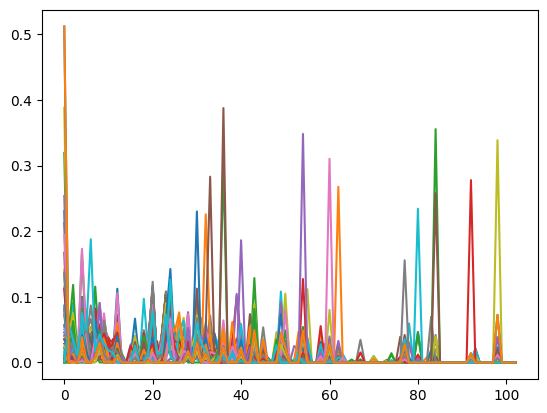

In [57]:
conv = X @ np.array(coefs)
# set negative values to 0
conv = np.where(conv < 0, 0, conv)
# normalize
for row in conv:
    row /= np.sum(row)


# user preferences ?!?!
for i in range(len(conv)):
  plt.plot(conv[i])